# Customer Segmentation using RFM

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

data = pd.read_csv("C:\\Users\\priya\\OneDrive\\Desktop\\Updated_DMAAssignment2.2\\Digital-Marketing-Analytics\\Datasets\\Invoice.csv")
data.head()

,InvoiceNo,Quantity,InvoiceDate,UnitPrice,CustomerID
0,536365,6,12/1/2010 8:26,2.55,17850.0
1,536365,6,12/1/2010 8:26,3.39,17850.0
2,536365,8,12/1/2010 8:26,2.75,17850.0
3,536365,6,12/1/2010 8:26,3.39,17850.0
4,536365,6,12/1/2010 8:26,3.39,17850.0


In [3]:
# Since this file takes some time to load, let's 'backup' it.
bkp = data

In [4]:
data.isna().any()

InvoiceNo      False
Quantity       False
InvoiceDate    False
UnitPrice      False
CustomerID      True
dtype: bool

In [5]:
data = data[pd.notnull(data['CustomerID'])]
data.isna().any()

InvoiceNo      False
Quantity       False
InvoiceDate    False
UnitPrice      False
CustomerID     False
dtype: bool

In [6]:
data.nunique()

InvoiceNo      22190
Quantity         436
InvoiceDate    20460
UnitPrice        620
CustomerID      4372
dtype: int64

In [7]:
data = data[data.Quantity >= 0]
data.describe()

,Quantity,UnitPrice,CustomerID
count,397924.000000,397924.000000,397924.000000
mean,13.021823,3.116174,15294.315171
std,180.420210,22.096788,1713.169877
min,1.000000,0.000000,12346.000000
25%,2.000000,1.250000,13969.000000
50%,6.000000,1.950000,15159.000000
75%,12.000000,3.750000,16795.000000
max,80995.000000,8142.750000,18287.000000


In [8]:
import datetime as dt

print('Most recent invoice is from:')
print(data['InvoiceDate'].max())

lastDate = dt.datetime(2011,12,10)
data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate'])

Most recent invoice is from:
9/9/2011 9:52


In [9]:
data['TotalPrice'] = data.UnitPrice * data.Quantity

In [10]:
rfmTable = data.groupby('CustomerID').agg({'InvoiceDate': lambda x: (lastDate - x.max()).days, 
                                           'InvoiceNo': lambda x: len(x), 
                                           'TotalPrice': lambda x: x.sum()})
rfmTable['InvoiceDate'] = rfmTable['InvoiceDate'].astype(int)
rfmTable.rename(columns={'InvoiceDate': 'recency', 
                         'InvoiceNo': 'frequency', 
                         'TotalPrice': 'monetary'}, inplace=True)

rfmTable.head()

,recency,frequency,monetary
CustomerID,,,
12346.0,325,1,77183.60
12347.0,2,182,4310.00
12348.0,75,31,1797.24
12349.0,18,73,1757.55
12350.0,310,17,334.40


In [12]:
#Create f_score

f_score = []
m_score = []
r_score = []

columns = ['frequency', 'monetary']
scores_str = ['f_score', 'm_score']
scores = [f_score, m_score]

for n in range(len(columns)):
    # Order by column
    rfmTable = rfmTable.sort_values(columns[n], ascending=False)
    
    # Create new index
    refs = np.arange(1,4340)
    rfmTable['refs'] = refs
    
    # Add score
    for i, row in rfmTable.iterrows():
        if row['refs'] <= 866:
            scores[n].append(5)
        elif row['refs'] > 866 and row['refs'] <= 866*2:
            scores[n].append(4)
        elif row['refs'] > 866*2 and row['refs'] <= 866*3:
            scores[n].append(3)
        elif row['refs'] > 866*3 and row['refs'] <= 866*4:
            scores[n].append(2)
        else: 
            scores[n].append(1)

    # Create f_score column
    rfmTable[scores_str[n]] = scores[n]
    
# For recency, we do the opposite: most recents are better, so we order as ascending
rfmTable = rfmTable.sort_values('recency', ascending=True)
    
# Recreate index
refs = np.arange(1,4340)
rfmTable['refs'] = refs
    
# Add score
for i, row in rfmTable.iterrows():
    if row['refs'] <= 866:
        r_score.append(5)
    elif row['refs'] > 866 and row['refs'] <= 866*2:
        r_score.append(4)
    elif row['refs'] > 866*2 and row['refs'] <= 866*3:
        r_score.append(3)
    elif row['refs'] > 866*3 and row['refs'] <= 866*4:
        r_score.append(2)
    else: 
        r_score.append(1)

# Create f_score column
rfmTable['r_score'] = r_score
    
rfmTableScores = rfmTable.drop(['frequency', 'monetary', 'recency', 'refs'], axis=1)

rfmTableScores.head(5)

,f_score,m_score,r_score
CustomerID,,,
13426.0,5,5,5
12423.0,5,4,5
12518.0,5,4,5
17389.0,5,5,5
14446.0,5,4,5


In [13]:
from sklearn.cluster import KMeans

wcss = []
for i in range(1,11):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=0)
    kmeans.fit(rfmTableScores)
    wcss.append(kmeans.inertia_)

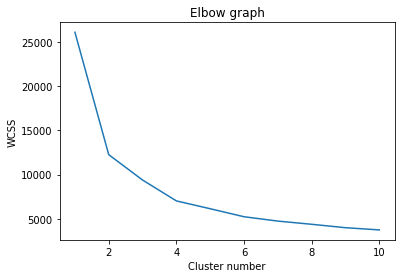

In [14]:
plt.plot(range(1,11), wcss)
plt.title('Elbow graph')
plt.xlabel('Cluster number')
plt.ylabel('WCSS')
plt.show()

In [16]:
kmeans = KMeans(n_clusters=4, init='k-means++', random_state=0)
clusters = kmeans.fit_predict(rfmTableScores)

In [17]:
rfmTable['clusters'] = clusters
rfmTable.head()

,recency,frequency,monetary,refs,f_score,m_score,r_score,clusters
CustomerID,,,,,,,,
13426.0,0,157,3641.32,1,5,5,5,2
12423.0,0,125,1859.31,2,5,4,5,2
12518.0,0,124,2056.89,3,5,4,5,2
17389.0,0,213,31833.68,4,5,5,5,2
14446.0,0,293,1039.58,5,5,4,5,2


Text(0.5, 0, 'Monetary')

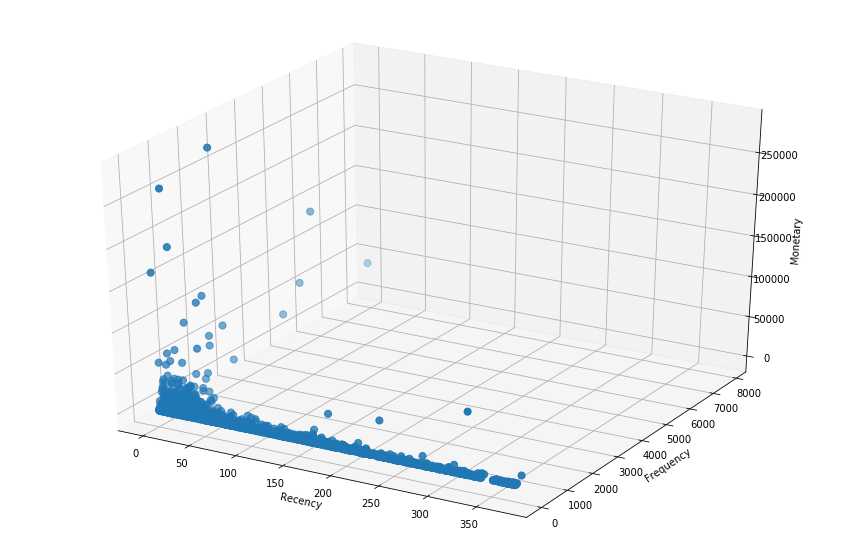

In [18]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(rfmTable.recency, rfmTable.frequency, rfmTable.monetary, s=50)

ax.set_xlabel('Recency')
ax.set_ylabel('Frequency')
ax.set_zlabel('Monetary')

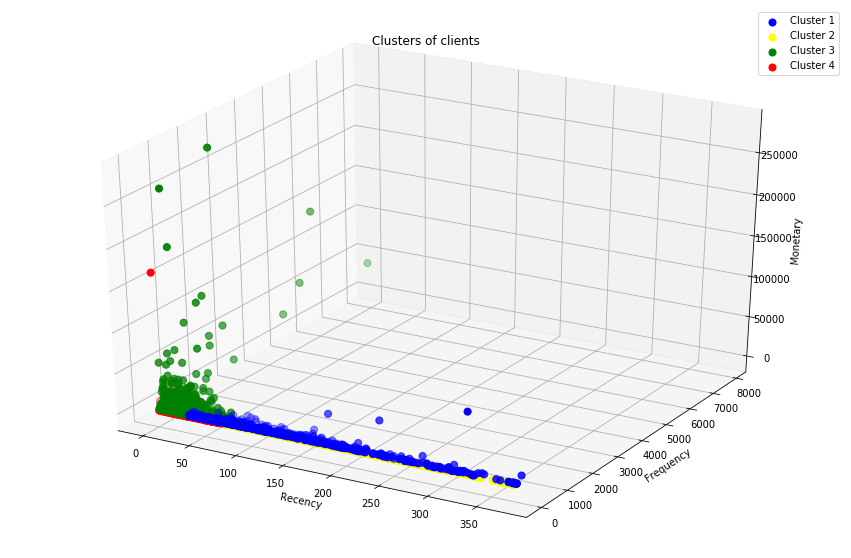

In [19]:
fig = plt.figure(figsize=(15,10))
dx = fig.add_subplot(111, projection='3d')
colors = ['blue', 'yellow', 'green', 'red']

for i in range(0,4):
    dx.scatter(rfmTable[rfmTable.clusters == i].recency, 
               rfmTable[rfmTable.clusters == i].frequency, 
               rfmTable[rfmTable.clusters == i].monetary, 
               c = colors[i], 
               label = 'Cluster ' + str(i+1), 
               s=50)

dx.set_title('Clusters of clients')
dx.set_xlabel('Recency')
dx.set_ylabel('Frequency')
dx.set_zlabel('Monetary')
dx.legend()

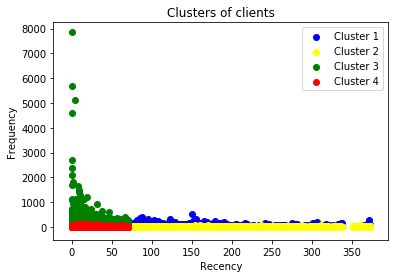

In [20]:
c1 = rfmTable[rfmTable.clusters == 0]
c2 = rfmTable[rfmTable.clusters == 1]
c3 = rfmTable[rfmTable.clusters == 2]
c4 = rfmTable[rfmTable.clusters == 3]

plt.scatter(c1.recency, c1.frequency, c = 'blue', label = 'Cluster 1')
plt.scatter(c2.recency, c2.frequency, c = 'yellow', label = 'Cluster 2')
plt.scatter(c3.recency, c3.frequency, c = 'green', label = 'Cluster 3')
plt.scatter(c4.recency, c4.frequency, c = 'red', label = 'Cluster 4')

plt.title('Clusters of clients')
plt.xlabel('Recency')
plt.ylabel('Frequency')
plt.legend()

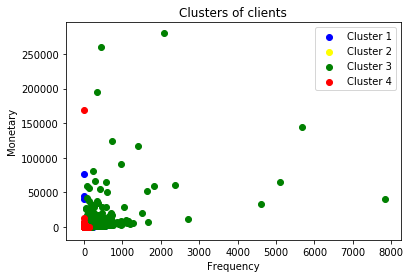

In [21]:
c1 = rfmTable[rfmTable.clusters == 0]
c2 = rfmTable[rfmTable.clusters == 1]
c3 = rfmTable[rfmTable.clusters == 2]
c4 = rfmTable[rfmTable.clusters == 3]

plt.scatter(c1.frequency, c1.monetary, c = 'blue', label = 'Cluster 1')
plt.scatter(c2.frequency, c2.monetary, c = 'yellow', label = 'Cluster 2')
plt.scatter(c3.frequency, c3.monetary, c = 'green', label = 'Cluster 3')
plt.scatter(c4.frequency, c4.monetary, c = 'red', label = 'Cluster 4')

plt.title('Clusters of clients')
plt.xlabel('Frequency')
plt.ylabel('Monetary')
plt.legend()

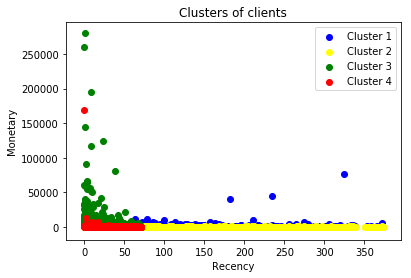

In [22]:
c1 = rfmTable[rfmTable.clusters == 0]
c2 = rfmTable[rfmTable.clusters == 1]
c3 = rfmTable[rfmTable.clusters == 2]
c4 = rfmTable[rfmTable.clusters == 3]

plt.scatter(c1.recency, c1.monetary, c = 'blue', label = 'Cluster 1')
plt.scatter(c2.recency, c2.monetary, c = 'yellow', label = 'Cluster 2')
plt.scatter(c3.recency, c3.monetary, c = 'green', label = 'Cluster 3')
plt.scatter(c4.recency, c4.monetary, c = 'red', label = 'Cluster 4')

plt.title('Clusters of clients')
plt.xlabel('Recency')
plt.ylabel('Monetary')
plt.legend()